# Default Loan Prediction

This is a group project.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import cross_validation
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE 
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# Loans data
## Loading and transforming categorical values

In [3]:
loans= pd.read_csv("loans.csv")
#check any null
#loans[loans.isnull().any(axis=1)]
#check the data type
#loans.dtypes

In [4]:
cat_col=loans.select_dtypes(include=["object"]).columns
#for i in cat_col:
#    print(sorted(set(loans[str(i)])))
for i in cat_col:
    loans[str(i)]=loans[str(i)].astype('category').cat.codes

In [5]:
cat_col_dd = cat_col[2:]

## One Hot enconder
Creates new variables for categorical variables that are not ordinal and have multiple levels. 

In [7]:
loans = pd.get_dummies(loans, columns=cat_col_dd)

To avoid perfect colinearity it is important to remove one of the dummies for each feature

In [8]:
loans = loans.drop(['home_ownership_0', 'verification_status_0', 'issue_d_0', 'purpose_0', 'initial_list_status_0', 'application_type_0'], axis = 1)
loans.head()

,loan_status,term,installment,grade,annual_inc,delinq_2yrs,earliest_cr_line,inq_last_6mths,pub_rec,revol_bal,...,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,initial_list_status_1,application_type_1
0,0,36,322.35,1,105000.0,1,2010,0,0,4055,...,0,0,0,1,0,0,0,0,0,0
1,0,36,1241.50,0,150000.0,0,1998,0,0,38863,...,0,0,0,0,0,0,0,0,1,0
2,0,36,321.64,2,90000.0,0,1997,3,0,51954,...,0,0,0,0,0,0,0,0,0,0
3,0,36,324.65,1,50000.0,0,2004,1,0,7507,...,0,0,0,0,0,0,0,0,1,0
4,0,36,171.09,2,87000.0,0,1999,1,0,21007,...,0,0,0,0,1,0,0,0,1,0


In [52]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11750 entries, 0 to 11749
Data columns (total 53 columns):
loan_status              11750 non-null int8
term                     11750 non-null int64
installment              11750 non-null float64
grade                    11750 non-null int8
annual_inc               11750 non-null float64
delinq_2yrs              11750 non-null int64
earliest_cr_line         11750 non-null int64
inq_last_6mths           11750 non-null int64
pub_rec                  11750 non-null int64
revol_bal                11750 non-null int64
total_acc                11750 non-null int64
total_rec_prncp          11750 non-null float64
total_rec_int            11750 non-null float64
tot_cur_bal              11750 non-null int64
open_acc_6m              11750 non-null int64
open_act_il              11750 non-null int64
open_il_12m              11750 non-null int64
open_il_24m              11750 non-null int64
total_bal_il             11750 non-null int64
open_rv_12m

## Split 80% training set and 20% test set

In [9]:
#split the data into training and test set
train_loans,test_loans=train_test_split(loans,test_size=0.2,random_state=42, shuffle=True)

## Distribution of the variables

From the below histograms of all varibles, we notice that all of them are not roughly uniform, and they have several outliers. Therefore, we would like to use Z-score normalisation before applying some of the machine learining techniques.

/Users/stuart/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


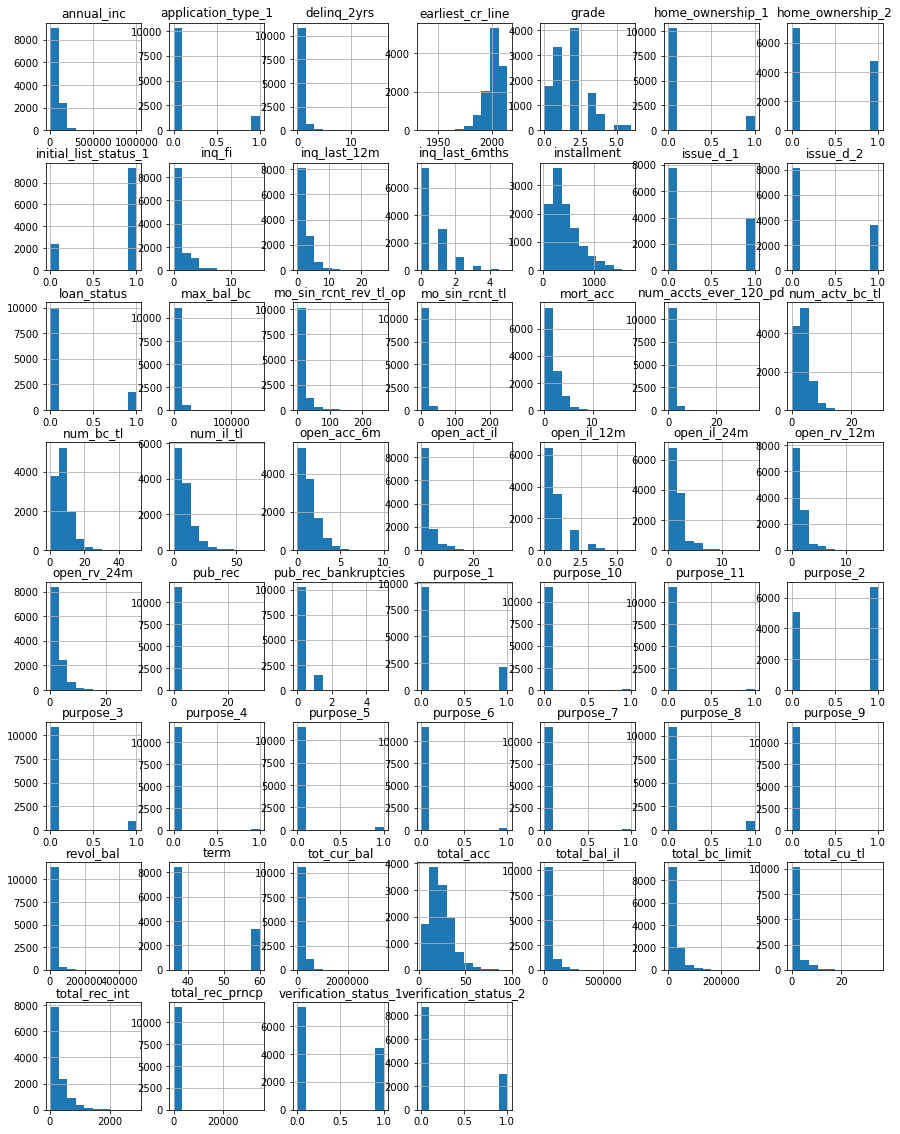

In [10]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
loans.hist(ax = ax)
plt.show()

## Normalisation

After scaling the final data sets are defined as:

* **x** - non scaled x training data set
* **x_scale** - normalised x training data set
* **y** - loan status for training set

* **test_x** - non scaled x test data set
* **test_x_scale** - normalised x test data set
* **test_y** - loan status for test set

In [13]:
scaler = StandardScaler().fit(train_loans.iloc[:,1:])
train_loans_scale = scaler.transform(train_loans.iloc[:,1:])
test_loans_scale = scaler.transform(test_loans.iloc[:,1:])

In [14]:
#Training set
x=train_loans.iloc[:,1:].reset_index(drop=True)
x_scale=pd.DataFrame(train_loans_scale, columns = x.columns).reset_index(drop=True) #converting it back to a data frame
y = train_loans.iloc[:,0]

#Test set
test_x=pd.DataFrame(test_loans.iloc[:,1:]).reset_index(drop=True)
test_x_scale=pd.DataFrame(test_loans_scale, columns = x.columns).reset_index(drop=True) #converting it back to a data frame
test_y=test_loans.iloc[:,0]

## QDA

In [15]:
m1 = QuadraticDiscriminantAnalysis()
m1.fit(x_scale, y)
m1_scores = cross_validation.cross_val_score(m1, x_scale,y,cv=10)
m1_pred = cross_validation.cross_val_predict(m1,x_scale,y,cv=10)
m1_conf=pd.DataFrame(confusion_matrix(y,m1_pred))
print(m1_scores.mean())
print(m1_conf)
print("fail_sensitivity",round(m1_conf.iloc[1,1]/(m1_conf.iloc[1,0]+m1_conf.iloc[1,1]),4))

0.806164083457
      0    1
0  7231  756
1  1066  347
fail_sensitivity 0.2456


## Tree

In [16]:
m2 = tree.DecisionTreeClassifier()
m2.fit(x_scale,y)
m2_scores = cross_validation.cross_val_score(m2, x_scale,y,cv=10)
print("accuracy score", m2_scores.mean())
m2_pred = cross_validation.cross_val_predict(m2,x_scale,y,cv=10)
m2_conf=pd.DataFrame(confusion_matrix(y,m2_pred))
print(m2_conf)
print("fail_precision",round(m2_conf.iloc[1,1]/(m2_conf.iloc[1,0]+m2_conf.iloc[1,1]),4))

accuracy score 0.867234968288
      0    1
0  7354  633
1   618  795
fail_precision 0.5626


## 5NN

In [17]:
m3= KNeighborsClassifier(5)
m3.fit(x_scale,y)
m3_scores = cross_validation.cross_val_score(m3, x_scale,y,cv=10)
print(m3_scores.mean())
m3_pred = cross_validation.cross_val_predict(m3,x_scale,y,cv=10)
m3_conf=pd.DataFrame(confusion_matrix(y,m3_pred))
print(m3_conf)
print("fail_precision",round(m3_conf.iloc[1,1]/(m3_conf.iloc[1,0]+m3_conf.iloc[1,1]),4))

0.843085452164
      0    1
0  7845  142
1  1333   80
fail_precision 0.0566


# Reduced vs full (intuitive)

We choose the attributes: 

1) annual_inc: we expect people with high income levels to be less likely to default. Especially when considered against total current balance of all accounts and installment. 

2) revol_bal: the size of the revolving credit extended to people is an indicator of the trust the creditor has in the debtor to not default 

3) grade: loan grade is an indicator of the price against which a debtor borrows, which is directly based on the risk-level of default 

4) home_ownership: status of home ownership is an indicator of both the ability of a person to raise funds to acquire a home, as of the total capital-strength of a debtor 

5) installment: the higher the installment, the sooner someone defaults if they run into financial problems

6) num_accts_ever_120_pd: indicator of a person's historical ability to repay debts, as well as a potential indicator that the person is currently running into financial trouble 

7) open_il_24m: when people open new installments rapidly after another this can be an indication that a person is financing its debt with other debt, revealing a potential heading for default 

8) purpose: different purposes of lending come with different levels of riskiness

9) tot_cur_bal: total size of the debt relative to annual income reveals how hard it is for someone to repay all debts 

10) verification_status: verified income level increases trust in level of income to repay debt

In [18]:
intu_red_var = ['annual_inc', 'revol_bal', 'grade', 'home_ownership_1','home_ownership_1', 'installment',
                'num_accts_ever_120_pd', 'open_il_12m','tot_cur_bal','verification_status_1','verification_status_2',
                'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6',
                'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10','purpose_11']

x_scaled_intu = x_scale[intu_red_var]
x_test_intu = test_x_scale[intu_red_var]

########################

#To see results on the ridge-reduced variables for all models, unhash the below code

#x_scaled_intu = x_scale[top_ind]
#x_test_intu = test_x_scale[top_ind]


## Logistic Regression

In [19]:
m1_linreg = linear_model.LogisticRegression()
m1_linreg.fit(x_scaled_intu, y)

m1_scores = cross_validation.cross_val_score(m1_linreg, x_scaled_intu,y,cv=10)
print(round(m1_scores.mean(),4))


m1_linreg_pred = cross_validation.cross_val_predict(m1_linreg,x_scaled_intu,y,cv=10)
m1_linreg_conf=pd.DataFrame(confusion_matrix(y,m1_linreg_pred))
print("fail_sensitivity",round(m1_linreg_conf.iloc[1,1]/(m1_linreg_conf.iloc[1,0]+m1_linreg_conf.iloc[1,1]),4))

0.8487
fail_sensitivity 0.0127


## Tree

In [20]:
m2_redTree = tree.DecisionTreeClassifier()
m2_redTree.fit(x_scaled_intu,y)

m2_scores = cross_validation.cross_val_score(m2_redTree, x_scaled_intu,y,cv=10)
print(round(m2_scores.mean(),4))

m2_redTree_pred = cross_validation.cross_val_predict(m2_redTree,x_scaled_intu,y,cv=10)
m2_redTree_conf=pd.DataFrame(confusion_matrix(y,m2_redTree_pred))
print("fail_sensitivity",round(m2_redTree_conf.iloc[1,1]/(m2_redTree_conf.iloc[1,0]+m2_redTree_conf.iloc[1,1]),4))

0.7482
fail_sensitivity 0.2067


# 5- KNN

In [21]:
m5_redKNN = KNeighborsClassifier(5)
m5_redKNN.fit(x_scaled_intu,y)
m5_scores = cross_validation.cross_val_score(m5_redKNN, x_scaled_intu,y,cv=10)
print(round(m5_scores.mean(),4))

m5_redKNN_pred = cross_validation.cross_val_predict(m5_redKNN,x_scaled_intu,y,cv=10)
m5_redKNN_conf=pd.DataFrame(confusion_matrix(y,m5_redKNN_pred))
print("fail_sensitivity",round(m5_redKNN_conf.iloc[1,1]/(m5_redKNN_conf.iloc[1,0]+m5_redKNN_conf.iloc[1,1]),4))

0.8339
fail_sensitivity 0.0517


# Ridge regression

In [22]:
ridgecv = linear_model.LogisticRegressionCV(Cs = 100, penalty='l2', cv =10, solver='newton-cg')
ridgecv.fit(x_scale, y)

LogisticRegressionCV(Cs=100, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='newton-cg', tol=0.0001,
           verbose=0)

In [23]:
c = ridgecv.C_
c[0]

0.14174741629268062

In [24]:
ridgecv.score(x_scale, y)

0.87106382978723407

## Ridge reduced model

In [25]:
ridge = linear_model.LogisticRegression(penalty='l2', C=c[0], solver='newton-cg')
ridge.fit(x_scale, y)

LogisticRegression(C=0.14174741629268062, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [26]:
betas = pd.DataFrame(np.transpose(ridge.coef_), columns = ['Beta_i'], index=x.columns)
betas = betas.abs().sort_values('Beta_i',ascending= False)
top = betas[0:30]
betas

,Beta_i
total_rec_int,1.777085
installment,1.149222
issue_d_2,0.813457
grade,0.774591
total_rec_prncp,0.756365
issue_d_1,0.709822
term,0.176507
purpose_2,0.149325
purpose_1,0.148511
total_bc_limit,0.126516


In [27]:
# the count of true negatives is C_{0,0}, 
# false negatives is C_{1,0}, 
#true positives is C_{1,1} and 
#false positives is C_{0,1}.
pred = pd.DataFrame(ridge.predict(x_scale))
m4_conf=pd.DataFrame(confusion_matrix(y,pred))
print(m4_conf)
print('Sensitive',round(m4_conf.iloc[1,1]/(m4_conf.iloc[1,0]+m4_conf.iloc[1,1]),4) )
print("Specificity",round(m4_conf.iloc[0,0]/(m4_conf.iloc[0,1]+m4_conf.iloc[0,0]),4))

      0    1
0  7861  126
1  1086  327
Sensitive 0.2314
Specificity 0.9842


In [28]:
top_ind = ['total_rec_int', 'installment', 'issue_d_1', 'issue_d_2', 'grade',
           'total_rec_prncp','term','total_bc_limit','open_il_24m','application_type_1',
           'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6',
           'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10','purpose_11'] 

## New data frame with only the top 10 variables

In [29]:
reduced_x = x_scale[top_ind]
reduced_x_test = test_x_scale[top_ind]

In [30]:
ridge_red = linear_model.LogisticRegression(penalty='l2', C=c[0])
ridge_red.fit(reduced_x, y)

LogisticRegression(C=0.14174741629268062, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [31]:
ridge_red.score(reduced_x, y)

0.8713829787234042

In [32]:
pred_red = pd.DataFrame(ridge_red.predict(reduced_x))
m5_conf=pd.DataFrame(confusion_matrix(y,pred_red))
print(m5_conf)
print('Sensitive',round(m5_conf.iloc[1,1]/(m5_conf.iloc[1,0]+m5_conf.iloc[1,1]),4) )
print("Specificity",round(m5_conf.iloc[0,0]/(m5_conf.iloc[0,1]+m5_conf.iloc[0,0]),4))

      0    1
0  7876  111
1  1098  315
Sensitive 0.2229
Specificity 0.9861


# Q10 Using SMOTE

Using the set of variables from the Ridge-Model, SMOTE is performed for the Ridge-Reduce-Model


In [33]:
sm = SMOTE(random_state=42)
kf = KFold(n_splits=10,shuffle=True)
#list of 10-fold data set
ks=[]
for i in kf.split(X=reduced_x,y=y):
    ks.append(i)
#list of 10-fold-SMOTE data set
xs_smote=[]    
ys_smote=[]
#ks[i][0],the training set of the i fold
#ks[i][1],the test set of the i fold
for i in range(10):
    x_smote,y_smote=sm.fit_sample(x.iloc[ks[i][0],],y.iloc[ks[i][0],])
    xs_smote.append(x_smote)
    ys_smote.append(y_smote)

## SMOTE Decision Tree

In [34]:
m2_smote_conf=pd.DataFrame([[0,0],[0,0]])
#sum the confusion matrix for all 10 folds
for i in range(10):
    m2_smote = tree.DecisionTreeClassifier()
    m2_smote.fit(xs_smote[i],ys_smote[i])
    pred =(m2_smote.predict(x.iloc[ks[i][1]]))
    m2_smote_conf += pd.DataFrame(confusion_matrix(y.iloc[ks[i][1],],pred))
print(m2_smote_conf)
print("fail_precision",round(m2_smote_conf.iloc[1,1]/(m2_smote_conf.iloc[1,0]+m2_smote_conf.iloc[1,1]),4))
print("accuracy",round((m2_smote_conf.iloc[1,1]+m2_smote_conf.iloc[0,0])/m2_smote_conf.sum().sum(),4))

      0    1
0  7211  776
1   656  757
fail_precision 0.5357
accuracy 0.8477


After SMOTE, the accuracy decreases from 0.869 to 0.847 but the fail_precision increases from 0.549 to 0.535

## SMOTE 5-NN

In [35]:
m3_smote_conf=pd.DataFrame([[0,0],[0,0]])
#sum the confusion matrix for all 10 folds
for i in range(10):
    m3_smote = KNeighborsClassifier(5)
    m3_smote.fit(xs_smote[i],ys_smote[i])
    pred =(m3_smote.predict(x.iloc[ks[i][1]]))
    m3_smote_conf += pd.DataFrame(confusion_matrix(y.iloc[ks[i][1],],pred))
print(m3_smote_conf)
print("fail_precision",round(m3_smote_conf.iloc[1,1]/(m3_smote_conf.iloc[1,0]+m3_smote_conf.iloc[1,1]),4))
print("accuracy",round((m3_smote_conf.iloc[1,1]+m3_smote_conf.iloc[0,0])/m3_smote_conf.sum().sum(),4))

      0     1
0  4924  3063
1   854   559
fail_precision 0.3956
accuracy 0.5833


After SMOTE, the accuracy decreases from 0.871 to 0.582 but fail presicion increases from 0.176 to 0.398

# SMOTE Ridge

In [36]:
m4_smote_conf=pd.DataFrame([[0,0],[0,0]])
#sum the confusion matrix for all 10 folds
for i in range(10):
    m4_smote = linear_model.LogisticRegression(penalty='l2', C=c[0])
    m4_smote.fit(xs_smote[i],ys_smote[i])
    pred =(m4_smote.predict(x.iloc[ks[i][1]]))
    m4_smote_conf += pd.DataFrame(confusion_matrix(y.iloc[ks[i][1],],pred))
print(m4_smote_conf)
print("fail_precision",round(m4_smote_conf.iloc[1,1]/(m4_smote_conf.iloc[1,0]+m4_smote_conf.iloc[1,1]),4))
print("accuracy",round((m4_smote_conf.iloc[1,1]+m4_smote_conf.iloc[0,0])/m4_smote_conf.sum().sum(),4))

      0     1
0  6227  1760
1   389  1024
fail_precision 0.7247
accuracy 0.7714


After SMOTE, the accuracy decreases from 0.8709574 to 0.7687 but fail presicion increases from 0.228 to 0.7696

# SMOTE Logistic Regression

In [79]:
m5_smote_conf=pd.DataFrame([[0,0],[0,0]])
#sum the confusion matrix for all 10 folds
for i in range(10):
    m5_smote = linear_model.LogisticRegression()
    m5_smote.fit(xs_smote[i],ys_smote[i])
    pred =(m5_smote.predict(x.iloc[ks[i][1]]))
    m5_smote_conf += pd.DataFrame(confusion_matrix(y.iloc[ks[i][1],],pred))
print(m4_smote_conf)
print("fail_precision",round(m5_smote_conf.iloc[1,1]/(m5_smote_conf.iloc[1,0]+m5_smote_conf.iloc[1,1]),4))
print("accuracy",round((m5_smote_conf.iloc[1,1]+m5_smote_conf.iloc[0,0])/m5_smote_conf.sum().sum(),4))

      0     1
0  6222  1765
1   401  1012
fail_precision 0.7247
accuracy 0.7698


In [118]:
(((0.769-0.23)/0.23))*100

234.34782608695653

After SMOTE, the accuracy decreases from to 0.769 but fail presicion increases from 0.23 to 0.769

# Performance on test set

## QDA & Logistic Regression

### QDA on full model - 40 variables

In [80]:
m1_pred = m1.predict(test_x_scale)
m1_conf=pd.DataFrame(confusion_matrix(test_y,m1_pred))
print(m1_conf)
print('Accuracy', round(m1.score(test_x_scale, test_y),4))
print('Sensitive',round(m1_conf.iloc[1,1]/(m1_conf.iloc[1,0]+m1_conf.iloc[1,1]),4) )
print("Specificity",round(m1_conf.iloc[0,0]/(m1_conf.iloc[0,1]+m1_conf.iloc[0,0]),4))

      0    1
0  1812  201
1   246   91
Accuracy 0.8098
Sensitive 0.27
Specificity 0.9001


### Lin Reg on Reduced Model - Intuition 

In [81]:
m1_pred2 = m1_linreg.predict(x_test_intu)
m1_conf=pd.DataFrame(confusion_matrix(test_y,m1_pred2))
print(m1_conf)
print('Accuracy', round(m1_linreg.score(x_test_intu, test_y),4))
print('Sensitive',round(m1_conf.iloc[1,1]/(m1_conf.iloc[1,0]+m1_conf.iloc[1,1]),4) )
print("Specificity",round(m1_conf.iloc[0,0]/(m1_conf.iloc[0,1]+m1_conf.iloc[0,0]),4))

      0  1
0  2008  5
1   333  4
Accuracy 0.8562
Sensitive 0.0119
Specificity 0.9975


## Decision Tree

### Full model - 40 variables

In [82]:
#m2.score(test_x_scale, test_y)

m2_pred = m2.predict(test_x_scale)
m2_conf=pd.DataFrame(confusion_matrix(test_y,m2_pred))
print(m2_conf)
print('Accuracy', round(m2.score(test_x_scale, test_y),4))
print('Sensitive',round(m2_conf.iloc[1,1]/(m2_conf.iloc[1,0]+m2_conf.iloc[1,1]),4) )
print("Specificity",round(m2_conf.iloc[0,0]/(m2_conf.iloc[0,1]+m2_conf.iloc[0,0]),4))

      0    1
0  1843  170
1   156  181
Accuracy 0.8613
Sensitive 0.5371
Specificity 0.9155


### Reduced - intuition

In [83]:
m2_pred = m2_redTree.predict(x_test_intu)
m2_conf=pd.DataFrame(confusion_matrix(test_y,m2_pred))
print(m2_conf)
print('Accuracy', round(m2_redTree.score(x_test_intu, test_y),4))
print('Sensitive',round(m2_conf.iloc[1,1]/(m2_conf.iloc[1,0]+m2_conf.iloc[1,1]),4) )
print("Specificity",round(m2_conf.iloc[0,0]/(m2_conf.iloc[0,1]+m2_conf.iloc[0,0]),4))

      0    1
0  1692  321
1   282   55
Accuracy 0.7434
Sensitive 0.1632
Specificity 0.8405


### With Ridge Reduce variables

In [90]:
m2_redTree2 = tree.DecisionTreeClassifier()
m2_redTree2.fit(reduced_x,y)

m2_pred = m2_redTree2.predict(reduced_x_test)
m2_conf=pd.DataFrame(confusion_matrix(test_y,m2_pred))
print(m2_conf)
print('Accuracy', round(m2_redTree2.score(reduced_x_test, test_y),4))
print('Sensitive',round(m2_conf.iloc[1,1]/(m2_conf.iloc[1,0]+m2_conf.iloc[1,1]),4) )
print("Specificity",round(m2_conf.iloc[0,0]/(m2_conf.iloc[0,1]+m2_conf.iloc[0,0]),4))

      0    1
0  1843  170
1   140  197
Accuracy 0.8681
Sensitive 0.5846
Specificity 0.9155


## Ridge

### Full model - 40 variables

In [93]:
pred = pd.DataFrame(ridge.predict(test_x_scale))
m4_conf=pd.DataFrame(confusion_matrix(test_y,pred))
print(m4_conf)
print('Accuracy', round(ridge.score(test_x_scale, test_y),4))
print('Sensitive',round(m4_conf.iloc[1,1]/(m4_conf.iloc[1,0]+m4_conf.iloc[1,1]),4) )
print("Specificity",round(m4_conf.iloc[0,0]/(m4_conf.iloc[0,1]+m4_conf.iloc[0,0]),4))

      0   1
0  1978  35
1   261  76
Accuracy 0.874
Sensitive 0.2255
Specificity 0.9826


### Ridge-reduced variables (10)

In [94]:
#ridge_red.score(reduced_x_test, test_y)
ridge_red_pred = ridge_red.predict(reduced_x_test)
ridge_red_conf=pd.DataFrame(confusion_matrix(test_y,ridge_red_pred))
print(ridge_red_conf)
print('Accuracy', round(ridge_red.score(reduced_x_test, test_y),4))
print('Sensitive',round(ridge_red_conf.iloc[1,1]/(ridge_red_conf.iloc[1,0]+ridge_red_conf.iloc[1,1]),4) )
print("Specificity",round(ridge_red_conf.iloc[0,0]/(ridge_red_conf.iloc[0,1]+ridge_red_conf.iloc[0,0]),4))

      0   1
0  1979  34
1   261  76
Accuracy 0.8745
Sensitive 0.2255
Specificity 0.9831


## 5-NN

### Full model

In [560]:
#m3.score(test_x_scale, test_y)

m3_pred = m3.predict(test_x_scale)
m3_conf=pd.DataFrame(confusion_matrix(test_y,m3_pred))
print(m3_conf)
print('Accuracy', round(m3.score(test_x_scale, test_y),4))
print('Sensitive',round(m3_conf.iloc[1,1]/(m3_conf.iloc[1,0]+m3_conf.iloc[1,1]),4) )
print("Specificity",round(m3_conf.iloc[0,0]/(m3_conf.iloc[0,1]+m3_conf.iloc[0,0]),4))

      0   1
0  1978  35
1   318  19
Accuracy 0.8498
Sensitive 0.0564
Specificity 0.9826
